# TO-DO

We need to try/finish to do:
- 1 Group: 
    - Implement attention map.
- 2 Group:
    - Try Ensemble on Classification (Potential Bright Idea :) 
    - Try different versions of Attention (ARPR).
    - Finish to implement testing functions

- Others:
    - Write AdaViT description in markdown cell
    - Train ViT Version vs AdaViT (time comparison in inference).
    - halting statistics plots (study correlation between halting metrics and epsilon (treshold = 0.5, 0.75, 0.85, 0. 95, 0.99)
    

# (AdaViT) ADAPTIVE VISION TRANSFORMERS

### SAPIENZA UNIVESITY of ROME (DEPARTMENT OF COMPUTER, CONTROL AND MANAGEMENT ENGINEEERING)

### COURSE IN ARTIFICIAL INTELLIGENCE AND ROBOTICS (ACADEMIC YEAR 2023/2024)

### NEURAL NETWORK's PROJECT
- Professors: SIMONE SCARDAPANE, DANILO COMMINIELLO 

### AUTHORS:
- **ALESSIO BORGI**
    - University ID: 1952442
    - Email: borgi.1952442@studenti.uniroma.it
- **ANGELO GIANFELICE**
    - University ID: 1851260
    - Email: gianfelice.1851260@studenti.uniroma.it
    
### 

## TABLE OF CONTENTS:
- **0: IMPORTING LIBRARIES AND SETTING THE SEEDS**
- **1: DATASET INSPECTION**
    - **1.1: CREATION OF THE LABEL DICTIONARY**
    - **1.2: DISPLAYING EXAMPLES OF THE DATASET (ENCODED LABELS)**
    - **1.3: DISPLAYING EXAMPLES OF THE DATASET (DECODED LABELS)**
- **2: DATA-MODULE DEFINITION**
    - **2.0: CUSTOMIZED TRANSFORM CLASS**
    - **2.1: CUSTOMIZED TRAINING SET VERSION**
    - **2.2: CUSTOMIZED VALIDATION SET VERSION**
    - **2.3: GENERAL DATA-MODULE DEFINITION**
    - **2.4: TESTING TRAINING AND VALIDATION DATALOADERS**

- **3: MODEL DEFINITION**
    - **3.0: PATCHING FUNCTION DEFINITION (PATCHIFYING)**
    - **3.1: DISPLAYING PATCHIFYING RESULT**
    - **3.2: POSITIONAL EMBEDDING DEFINITION**
        - **3.2.1: SINUSOIDAL POSITIONAL EMBEDDINGS (SPE)**
        - **3.2.2: ROTARY POSITIONAL EMBEDDINGS (RoPE)**
        - **3.2.3: VISUALIZE POSITIONAL EMBEDDINGS**

- **4:**
- **5:** 
- **6:** 

## INTRODUCTION

### (ViT) Vision Transformer's Idea

In this Notebook, we aim to present a clever implementation of **Vision Transformers (ViT)**. The Vision Transformer (ViT) represents a paradigm in computer vision by leveraging transformer-based architectures for **Image Classification** tasks. 

Unlike traditional **Convolutional Neural Networks (CNNs)**,which rely on local receptive fields (**Locality Principle**) and **Hierarchical Feature Extraction** through convolutional layers, ViT dispenses with the conventional convolutional layers and adopts a **Transformer Model**, originally designed for sequential data processing, such as in NLP("Natural Language Processing"). 

If we look this idea with a birds-eye point of view, we have that ViT's core idea involves treating an input image as a sequence of non-overlapping fixed-size patches, linearly embeds them, and appends learnable positional embeddings, that are added to encode spatial information. The resulting sequence of patch embeddings is then fed into a stack of transformer encoder blocks. Each transformer block consists of multi-head self-attention mechanisms and feedforward neural networks, enabling the model to capture both local and global contextual information, enhancing the model's ability to recognize complex patterns and relationships. 

One **ViT's distinguishing Feature** is its ability to **capture Long-Range Dependencies in Images** through self-attention, facilitating understanding of the visual content. This stands in contrast to CNNs, which may struggle with information propagation across distant image regions due to the locality of convolutional operations. ViT's self-attention mechanism allows it to efficiently model relationships between distant patches, promoting effective feature learning for image recognition. Moreover, ViT exhibits promising **Scalability Advantages**, particularly when dealing with large datasets and high-resolution images. The absence of spatial hierarchies in ViT's architecture enables more straightforward parallelization, facilitating training on powerful hardware accelerators. This scalability, coupled with competitive performance on standard image classification benchmarks, positions ViT as a versatile and efficient alternative to traditional CNN-based approaches.
from IPython.display import Image
<div style="text-align:center;">
    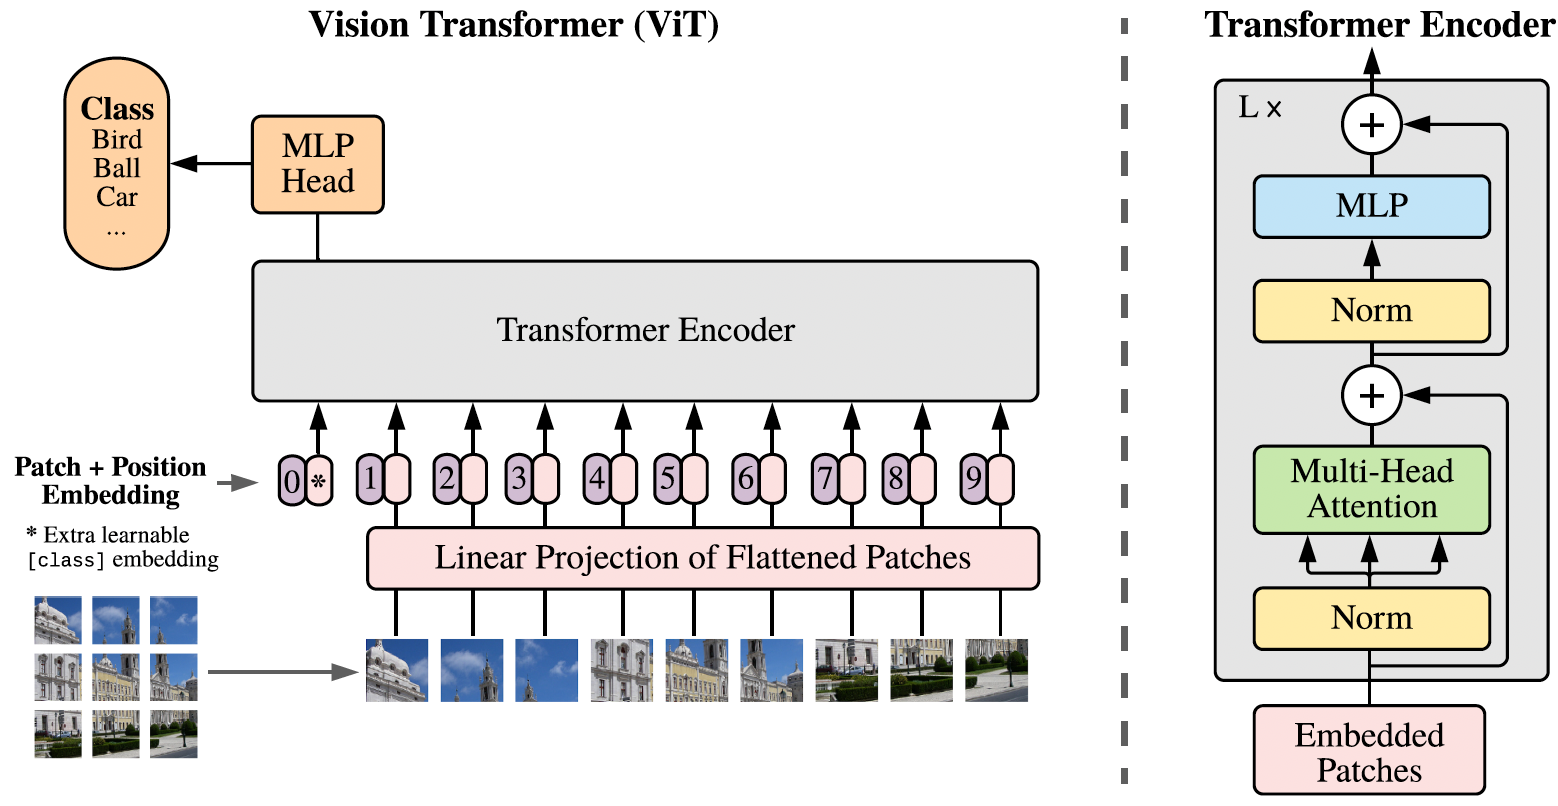
</div>


### (AdaViT) Adaptive Vision Transformer's Modification
Despite their remarkable advantages, Vision Transformers (ViTs) often face **Challenges** due to their fixed 2D positional encodings. This rigidity limits their ability to adapt to input image sizes and variations, hindering their applicability to real-world scenarios. To address these shortcomings, **Adaptive Vision Transformers (AdaViT)** emerge as a promising solution, introducing a **Dynamic Attention Mechanism** that allows the model to **selectively  take into account only Relevant Regions of the Input Image**, thereby overcoming the spatial resolution limitations of traditional ViTs. 

AdaViT enhances the vision transformer block by integrating an **Adaptive Halting Module**, which computes a **Halting Probability for each Token**. Remarkably, this module leverages the existing block parameters and utilizes a single neuron from the last dense layer in each block to calculate the halting probability, introducing **no additional Parameters** and **no additional Computational Overhead**. Tokens are discarded upon meeting the halting condition. Through the adaptive halting of tokens, we selectively perform dense computations only on those tokens considered informative for the given task. Consequently, as the vision transformer progresses through successive blocks, fewer tokens are processed, resulting in accelerated inference. 

This improvements leads to immediate and significant **Speed-Up at Inference Time** on standard computational platforms, without the need for additional tuning.

### ABSTRACT & CONTRIBUTIONS

The **Vision Transformer (ViT)** has emerged as a powerful architecture for Image Classification, but it faces challenges related to computational efficiency and adaptability to varying levels of task complexity. In response to these challenges, we delve into **Adaptive Vision Transformer (A-ViT)**, a method designed to enhance the adaptability and computational efficiency of ViT models.

The core contribution of our work is...

### 0: IMPORTING LIBRARIES AND SETTING THE SEEDS

In this stage, we import essential libraries and modules, laying the groundwork for subsequent code implementation and experimentation. Additionally, this step emphasizes the establishment of seed values, practice done for ensuring reproducibility in data processing, model training, and evaluation. 

In [ ]:

# Importing PyTorch-related Libraries.
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics.classification import Accuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

# Importing PyTorch Lightning-Related Libraries.
import pytorch_lightning as pl
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor, ModelCheckpoint

# Importing General Libraries.
import os
import csv
import PIL
import glob
import random
import numpy as np
from PIL import Image
import seaborn as sns
from pathlib import Path
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import OrderedDict


In [ ]:

def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results.
    
    Arguments:
        - seed {int} : Number of the seed.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    pl.seed_everything(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Set the seed.
seed_everything(31)

### 1: DATASET INSPECTION

We subsequently focus on experiencing a comprehensive exploration and understanding of the dataset at hand. This phase involves an in-depth examination of the data's structure, characteristics, and content. We delve into visualizing dataset images along with their corresponding labels. 

#### TINY IMAGENET
The **TinyImageNet** dataset is a subset of the 1.2 million images in ImageNet, specifically selected to be 20% as large as ImageNet while preserving the same distribution of classes. This makes it a more manageable dataset for our case where we have limited computational power, training and evaluating vision models, while still providing a challenging and diverse representation of real-world images.

TinyImageNet consists of **200 Classes, each** containing **640 Images**. The class distribution is similar to that of ImageNet, with a slight overrepresentation of animals and objects commonly found in everyday life. The images are downsampled to **64x64** pixels, making them smaller and less computationally expensive to handle than full-resolution ImageNet images.


#### 1.1: CREATION OF THE LABEL DICTIONARY

Here, we initiate the creation of a **Label Dictionary** to establish a meaningful mapping between encoded labels and their corresponding actual labels. The process extracts this from a file containing label information. The resulting dictionary serves as a key reference for interpreting encoded labels and facilitates a clearer understanding of the dataset's class labels. 

In [ ]:

# Initialize the Mapping Dictionary to be empty.
mapping_dict = {}

# Open the file in read mode.
with open('/kaggle/input/tiny-imagenet/tiny-imagenet-200/words.txt', 'r') as file:
    
    # Read each line from the file.
    for line in file:
        # Split the line into tokens based on whitespace.
        tokens = line.strip().split('\t')
        
        # Check if there are at least two tokens.
        if len(tokens) >= 2:
            # Extract the encoded label (left) and actual label (right).
            encoded_label, actual_label = tokens[0], tokens[1]
            
            # Add the mapping to the dictionary.
            mapping_dict[encoded_label] = actual_label

# Print the mapping dictionary.
#print(mapping_dict)


#### 1.2: DISPLAYING EXAMPLES OF THE DATASET (ENCODED LABELS)

In this exploration code, we aim to load and explore the **Tiny ImageNet** dataset. After loading the dataset, the class names and their respective counts are extracted. We visualize a grid containing ten randomly selected images from the dataset, showcasing both the image itself and its associated **Class Label (Encoded)**. 

In [ ]:

# Loading the dataset using ImageFolder.
dataset0 = datasets.ImageFolder(root="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/", transform=None)

# Extract class names and their counts.
class_names = dataset0.classes
class_counts = [dataset0.targets.count(i) for i in range(len(class_names))]

# Setting the seed.
np.random.seed(31)

# Create a grid of 10 images with labels.
plt.figure(figsize=(15, 8))

for i in range(10):
    
    # Randomly select an image and its corresponding label.
    index = np.random.randint(len(dataset0))
    image, encoded_label = dataset0[index]
    
    # Look up the actual label using the mapping dictionary.
    actual_label = mapping_dict.get(class_names[encoded_label], "Unknown Label")
    
    # Trim the label if it exceeds the maximum length.
    actual_label_trimmed = actual_label[:15] + '...' if len(actual_label) > 15 else actual_label

    # Display the image with its label..
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(image))  
    plt.title(f"Label: {actual_label_trimmed}", wrap=True)
    plt.axis('off')

# Displaying Dataset examples.
plt.tight_layout()
plt.show()

#### 1.3: DISPLAYING EXAMPLES OF THE DATASET (DECODED LABELS)

In this exploration code, we aim to load and explore the **Tiny ImageNet** dataset, together with the **(Decoded) Class Labels**, making use of the Label Dictionary extracted in *step 1.1*. 

In [ ]:

# Loading the dataset using ImageFolder.
dataset0 = datasets.ImageFolder(root="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/", transform=None)

# Extract class names and their counts.
class_names = dataset0.classes
class_counts = [dataset0.targets.count(i) for i in range(len(class_names))]

# Setting the seed.
np.random.seed(31)

# Create a grid of 10 images with labels.
plt.figure(figsize=(15, 8))

for i in range(10):
    
    # Randomly select an image and its corresponding label.
    index = np.random.randint(len(dataset0))
    image, encoded_label = dataset0[index]
    
    # Look up the actual label using the mapping dictionary.
    actual_label = mapping_dict.get(class_names[encoded_label], "Unknown Label")
    
    # Trim the label if it exceeds the maximum length.
    actual_label_trimmed = actual_label[:15] + '...' if len(actual_label) > 15 else actual_label

    # Display the image with its label..
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(image))  
    plt.title(f"Label: {actual_label_trimmed}", wrap=True)
    plt.axis('off')

# Displaying Dataset examples.
plt.tight_layout()
plt.show()

### 2: DATA-MODULE DEFINITION

#### 2.0: CUSTOMIZED TRANSFORM CLASS

We implement the **"AdaViT_Transformations" Class** in order to define and make some experiments including the application of a series of **Image Transformations** using the torchvision library. The __call__ method serves as the entry point for the transformation pipeline, taking an input image sample in the form of a PIL.Image.Image or a torch.Tensor. This class serves as a modular and extensible means to preprocess images before they are fed into the AdaViT model, allowing for flexibility in experimentation and ensuring the model's robustness to variations in input data. The augmentation process typically enhances the model's ability to learn from diverse visual patterns within the dataset, contributing to improved generalization and performance.

In [ ]:

class AdaViT_Transformations:
    
    def __init__(self):
        
        # Constructor - Nothing to initialize in this case
        pass

    def __call__(self, sample):
        """
        Call method to perform transformations on the input sample.

        Args:
        - sample (PIL.Image.Image or torch.Tensor): Input image sample.

        Returns:
        - transformed_sample (torch.Tensor): Transformed image sample.
        """

        # Define a series of image transformations using "torchvision.Compose" function.
        transform = transforms.Compose([
            transforms.ToTensor(),  
            # Additional transformations can be added here.
            # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
        ])

        # Apply the defined transformations to the input sample.
        transformed_sample = transform(sample)

        return transformed_sample

#### 2.1: CUSTOMIZED TRAINING SET VERSION
The following couple of sections, encompasses the development of a specific class for the **Training-Set Manipulation**. This class is devised with the explicit purpose of addressing unique requirements or modifications essential for the optimal training of the AdaViT model.


In [ ]:

class CustomTrainingTinyImagenet(ImageFolder):
    
    def __init__(self, root, transform=None):
        """
        Custom dataset class for Tiny ImageNet Training data.

        Args:
        - root (str): Root directory containing the dataset.
        - transform (callable, optional): Optional transform to be applied to the Input Image.
        """
        super(CustomTrainingTinyImagenet, self).__init__(root, transform=transform)

        # Create mappings between class labels and numerical indices
        self.class_to_index = {cls: idx for idx, cls in enumerate(sorted(self.classes))}
        self.index_to_class = {idx: cls for cls, idx in self.class_to_index.items()}

    def __getitem__(self, index):
        """
        Method to retrieve an item from the dataset.

        Args:
        - index (int): Index of the item to retrieve.

        Returns:
        - sample (torch.Tensor): Transformed image sample.
        - target (int): Numerical index corresponding to the class label.
        """
        # Retrieve the item and its label from the Dataset.
        path, target = self.samples[index]

        # Load the image using the default loader.
        sample = self.loader(path)

        # Apply the specified transformations, if any.
        if self.transform is not None:
            sample = self.transform(sample)

        # Adjust the directory depth to get the target label.
        target_str = os.path.basename(os.path.dirname(os.path.dirname(path)))

        # Convert string label to numerical index using the mapping.
        target = self.class_to_index[target_str]

        return sample, target

    def get_class_from_index(self, index):
        """
        Method to retrieve the class label from a numerical index.

        Args:
        - index (int): Numerical index corresponding to the class label.

        Returns:
        - class_label (str): Class label corresponding to the numerical index.
        """
        
        return self.index_to_class[index]

#### 2.2: CUSTOMIZED VALIDATION SET VERSION
As anticipated in the previous section, also this section, encompasses the development of a specific class, but this time aimed at the **Validation-Set Manipulation**. This class is devised with the explicit purpose of addressing unique requirements or modifications essential for the optimal Validation Process of the AdaViT model.

In [ ]:

class CustomValidationTinyImagenet(pl.LightningDataModule):
    
    def __init__(self, root, transform=None):
        """
        Custom data module for Tiny ImageNet Validation data.

        Args:
        - root (str): Root directory containing the dataset.
        - transform (callable, optional): Optional transform to be applied to the Input Image.
        """
        self.root = Path(root)
        self.transform = transform

        # Load and preprocess labels
        self.labels = self.load_labels()
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(set(self.labels.values())))}
        self.index_to_label = {idx: label for label, idx in self.label_to_index.items()}

    def load_labels(self):
        """
        Method to load and Pre-Process Labels from the Validation Dataset.

        Returns:
        - labels (dict): Dictionary mapping image names to labels.
        """
        label_path = "/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/val_annotations.txt"
        labels = {}

        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.split("\t")
            image_name, label = parts[0], parts[1]
            labels[image_name] = label

        return labels

    def __len__(self):
        """
        Method to get the length of the dataset.

        Returns:
        - length (int): Number of items in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, index):
        """
        Method to retrieve an item from the dataset.

        Args:
        - index (int): Index of the item to retrieve.

        Returns:
        - image (torch.Tensor): Transformed image sample.
        - label (int): Numerical index corresponding to the class label.
        """
        image_name = f"val_{index}.JPEG"
        image_path = self.root / image_name

        # Open the image using PIL and convert to RGB.
        image = Image.open(image_path).convert("RGB")

        # Apply the specified transformations, if any.
        if self.transform:
            image = self.transform(image)

        # Use the get method to handle cases where the key is not present.
        label_str = self.labels.get(image_name, 'Label not found')

        # Convert string label to numerical index using the mapping.
        label = self.label_to_index[label_str]

        return image, label

    def get_label_from_index(self, index):
        """
        Method to retrieve the class label from a numerical index.

        Args:
        - index (int): Numerical index corresponding to the class label.

        Returns:
        - class_label (str): Class label corresponding to the numerical index.
        """
        return self.index_to_label[index]

In [ ]:
class CustomTestTinyImagenet(pl.LightningDataModule):
    
    def __init__(self, root, transform=None):
        """
        Custom dataset class for Tiny ImageNet Test data.

        Args:
        - root (str): Root directory containing the dataset.
        - transform (callable, optional): Optional transform to be applied to the Input Image.
        """
        self.root = root
        self.transform = transform
        self.image_paths = self._get_image_paths()

    def __len__(self):
        """
        Method to get the total number of items in the dataset.

        Returns:
        - int: Total number of items in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, index):
        """
        Method to retrieve an item from the dataset.

        Args:
        - index (int): Index of the item to retrieve.

        Returns:
        - sample (torch.Tensor): Transformed image sample.
        - filename (str): Filename of the image.
        """
        # Get the image path based on the index.
        image_path = self.image_paths[index]

        # Load the image using the default loader.
        sample = Image.open(image_path)

        # Apply the specified transformations, if any.
        if self.transform is not None:
            sample = self.transform(sample)

        # Extract the filename from the image path.
        filename = os.path.basename(image_path)

        # Return a tuple containing the sample and filename.
        return sample, filename

    def _get_image_paths(self):
        """
        Helper method to get the paths of all images in the test dataset.

        Returns:
        - list: List of image paths.
        """
        image_paths = [os.path.join(self.root, filename) for filename in os.listdir(self.root)]
        return image_paths


#### 2.3: GENERAL DATA-MODULE DEFINITION

In this section, we wrote the **General Data Module**, denoted as **AViT_DataModule}**. This class extends $\texttt{pl.LightningDataModule}$ and serves as the cornerstone for loading and organizing datasets tailored for AViT model training and validation. The constructor takes essential parameters such as directory paths for the training and validation  datasets, batch size, and an optional argument for the number of workers in DataLoader.


In [ ]:

class AViT_DataModule(pl.LightningDataModule):
    
    def __init__(self, train_data_dir, val_data_dir, test_data_dir, batch_size, num_workers=4):
        """
        Custom data module for AViT model training and validation.

        Args:
        - train_data_dir (str): Directory path for the training dataset.
        - val_data_dir (str): Directory path for the validation dataset.
        - batch_size (int): Batch size for training and validation DataLoader.
        - num_workers (int, optional): Number of workers for DataLoader (default is 4).
        """
        super(AViT_DataModule, self).__init__()
        self.train_data_dir = train_data_dir
        self.val_data_dir = val_data_dir
        self.test_data_dir = test_data_dir
        self.batch_size = batch_size
        self.batch_size_test = 1
        self.num_workers = num_workers

        # Use AdaViT transformations for data augmentation
        self.transform = AdaViT_Transformations()

    def setup(self, stage=None):
        """
        Method to load and configure datasets for Training and Validation.

        Args:
        - stage (str, optional): 'fit' for Training and 'test' for Validation (default is None).
        """
        # Load Train dataset using CustomTrainingTinyImagenet with the new directory structure.
        self.train_dataset = CustomTrainingTinyImagenet(self.train_data_dir, transform=self.transform)

        # Load Validation dataset.
        self.val_dataset = CustomValidationTinyImagenet(self.val_data_dir, transform=self.transform)
        
        # Load Test dataset.
        self.test_dataset = CustomTestTinyImagenet(self.test_data_dir, transform=self.transform)

    def train_dataloader(self):
        """
        Method to return the DataLoader for the Training Dataset.

        Returns:
        - train_dataloader (DataLoader): DataLoader for Training.
        """
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        """
        Method to return the DataLoader for the Validation Dataset.

        Returns:
        - val_dataloader (DataLoader): DataLoader for Validation.
        """
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        """
        Method to return the DataLoader for the Test Dataset.

        Returns:
        - test_dataloader (DataLoader): DataLoader for Test Set.
        """
        return DataLoader(self.test_dataset, batch_size=self.batch_size_test, num_workers=self.num_workers)

#### 2.4: TESTING TRAINING AND VALIDATION DATALOADERS

In this section, the code is dedicated to testing the training, validation and test dataloaders implemented within the AViT_DataModule. The process involves setting up the data module with specified directories for training and validation datasets, followed by the visualization of both a pair of examples from the Training Batch, the Validation Batch, and Test Batch with their correspondent Label.



In [ ]:

def show_images_labels(images, labels, title):
    """
    Display Images with corresponding Labels.

    Parameters:
    - images (list of tensors): List of Image tensors.
    - labels (list): List of corresponding Labels.
    - title (str): Title for the entire subplot.

    Returns:
    None
    """
    # Create a Subplot with 1 row and len(images) columns.
    fig, axs = plt.subplots(1, len(images), figsize=(8, 4))
    
    # Set the title for the entire subplot.
    fig.suptitle(title)

    # Iterate over Images and Labels.
    for i, (img, label) in enumerate(zip(images, labels)):
        # Display each Image in a subplot.
        axs[i].imshow(transforms.ToPILImage()(img))
        
        # Set the title for each subplot with the corresponding label.
        axs[i].set_title(f"Label: {label}")
        
        # Turn off axis labels for better Visualization.
        axs[i].axis('off')

    # Show the entire subplot.
    plt.show()


In [ ]:
def show_images_test(images, title=None):
    """
    Function to display a set of images.

    Args:
    - images (list): List of images.
    - title (str, optional): Title for the plot (default is None).
    """
    # If there's only one image, convert it to a list for consistency.
    if not isinstance(images, list):
        images = [images]

    # Create a subplot based on the number of images.
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    # If there is only one image, axs will not be iterable.
    if num_images == 1:
        axs = [axs]

    # Iterate over images.
    for i, img in enumerate(images):
        # Display each image in a subplot.
        axs[i].imshow(transforms.ToPILImage()(img[0]))  # Assuming images are tensors
        axs[i].axis('off')

    # Set the title of the plot.
    if title:
        plt.title(title)

    # Show the plot.
    plt.show()


In [ ]:
# Define the AViT_DataModule.
data_module = AViT_DataModule(
    train_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/",
    val_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/images/",
    test_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/test/images/",
    batch_size=512
)

# Setup the Dataloaders.
data_module.setup()

# Get a batch from the Training DataLoader.
train_dataloader = data_module.train_dataloader()
train_batch = next(iter(train_dataloader))

# Get a batch from the Validation DataLoader.
val_dataloader = data_module.val_dataloader()
val_batch = next(iter(val_dataloader))

# Get a batch from the Test DataLoader.
test_dataloader = data_module.test_dataloader()
test_batch = next(iter(test_dataloader))

# Show two Images from the Training Batch.
show_images_labels(train_batch[0][:2], train_batch[1][:2], title='Training Batch')

# Show two Images from the Validation Batch.
show_images_labels(val_batch[0][:2], val_batch[1][:2], title='Validation Batch')

# Show two Images from the Test Batch.
show_images_test(test_batch[0][:1], title='Test Batch')


### 3: MODEL DEFINITION



#### 3.0: PATCHING FUNCTION DEFINITION (PATCHIFYING)

In input we get **3D Images** in the form $x \in R^{H\times W \times C}$. This images are processed, of course, in Batches, that, in our case is set, mostly to $b=512$, resulting in the Input being: $R^{B \times C \times H\times W}$. Images must be transformed into sequences, and for this reason we proceed to **dividing the Images** in a **Sequence of flattened 3D Patches**, through a process denoted as **Patchifying**, where the sequence of flattened patches is $x_{p} \in R^{N\times (P^{2} \cdot C)}$, where:

- **(H, W, C)**: This is Resolution of the Original Image, respectively being the **(H) Height**, **(W) Width**, and **(C) Channels**.
- **(P, P)**: This the Resolution of each image Patch. 
- **N**: This is the is the resulting number of patches, defined as: 
$$N = \frac{H \times W}{P^2}$$

In [ ]:

def Make_Patches_from_Image(images, n_patches):
    """
    Extract patches from input images.

    Parameters:
    - images (torch.Tensor): Input images tensor with shape (batch_size, channels, height, width).
    - n_patches (int): Number of patches in each dimension.

    Returns:
    torch.Tensor: Extracted patches tensor with shape (batch_size, n_patches^2, patch_size^2 * channels).
    """
    # Get the dimensions of the input images.
    n, c, h, w = images.shape

    # Ensure that the input images are square.
    assert h == w, "make_patches_from_image method is implemented for square images only!"

    # Initialize a tensor to store the extracted patches.
    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    # Loop over each image in the batch.
    for idx, image in enumerate(images):
        # Loop over each patch in both dimensions.
        for i in range(n_patches):
            for j in range(n_patches):
                # Extract the patch from the image.
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                # Flatten the patch and store it in the patches tensor.
                patches[idx, i * n_patches + j] = patch.flatten()

    return patches


#### 3.1: DISPLAYING PATCHIFYING RESULT

We proceed to test the **Patchifying Result**, by visualizying the patches that are outputted from the patchifying step. 

In [ ]:

# Helper function to Visualize Patches.
def visualize_patches(images, n_patches, title):
    """
    Visualize patches extracted from Images.

    Parameters:
    - images (torch.Tensor): Input images tensor with shape (batch_size, channels, height, width).
    - n_patches (int): Number of patches in each dimension.
    - title (str): Title for the entire subplot.

    Returns:
    None
    """
    # Extract patches from the input images using the make_patches_from_image function.
    patches = Make_Patches_from_Image(images, n_patches)
    
    # Create a subplot for visualizing patches.
    fig, axs = plt.subplots(n_patches, n_patches, figsize=(8, 8))
    fig.suptitle(title)
    
    # Calculate the patch size based on the input images.
    patch_size = images.shape[-1] // n_patches

    # Loop over each patch in both dimensions.
    for i in range(n_patches):
        for j in range(n_patches):
            # Calculate the index of the patch.
            patch_index = i * n_patches + j
            # Reshape each patch to (3, patch_size, patch_size).
            patch = patches[0, patch_index].reshape(3, patch_size, patch_size).cpu().numpy()
            # Display the patch in the subplot.
            axs[i, j].imshow(patch.transpose(1, 2, 0))
            axs[i, j].axis('off')

    # Show the entire subplot.
    plt.show()


In [ ]:
# Visualize patches for a Training Image.
visualize_patches(train_batch[0], n_patches=8, title='Training Patches')

# Visualize patches for a Validation Image.
visualize_patches(val_batch[0], n_patches=8, title='Validation Patches')

# Visualize patches for a Test Image.
visualize_patches(test_batch[0], n_patches=8, title='Test Patches')

#### 3.2: POSITIONAL EMBEDDING DEFINITION

We then proceed in the definition of the **Positional Embedding**. In the context of Transformer models, the inclusion of positional information is essential for capturing the sequential relationships within input sequences. Positional embeddings provide a means to convey the order or position of tokens in the input, contributing to the model's ability to understand the sequential structure of the data.


#### 3.2.1: SINUSOIDAL POSITIONAL EMBEDDINGS (SPE)

One common approach to generating positional embeddings is through the use of **Sine** and **Cosine Functions with varying frequencies**. The basic formulation for calculating **Sinusoidal Positional Embeddiings(SPE)** can be expressed as follows:

$$\text{{SPE}}(i, 2j) = \sin\left(\frac{i}{10000^{(2j/d)}}\right)$$

$$\text{{SPE}}(i, 2j + 1) = \cos\left(\frac{i}{10000^{(2j/d)}}\right)$$

Here, $i$ represents the position of the token in the sequence, $j$ represents the index of the embedding dimension, and $d$ is the total dimensionality of the embeddings. The function $\text{{PositionalEmbedding}}(i, j)$ returns the value of the positional embedding at position $i$ and dimension $j$.

In [ ]:

def get_positional_embeddings_SPE(sequence_length, d):
    """
    Generate Positional Embeddings for the Transformer Model.

    Parameters:
    - sequence_length (int): Length of the input sequence.
    - d (int): Dimension of the embeddings.

    Returns:
    torch.Tensor: Positional Embeddings tensor of shape (sequence_length, d).
    """
    # Generate a tensor of positions from 0 to sequence_length - 1.
    positions = torch.arange(0, sequence_length).float().view(-1, 1)
    
    # Calculate div_term for both sin and cos terms.
    div_term = torch.exp(torch.arange(0, d, 2).float() * -(np.log(10000.0) / d))

    # Initialize the embeddings tensor with zeros.
    embeddings = torch.zeros(sequence_length, d)
    
    # Compute sin and cos terms and assign them to the embeddings tensor.
    embeddings[:, 0::2] = torch.sin(positions / div_term)
    embeddings[:, 1::2] = torch.cos(positions / div_term)

    return embeddings

#### 3.2.2: ROTARY POSITIONAL EMBEDDINGS (RoPE)

The **Rotary Positional Embedding (RoPE)** is a technique used in Transformer models to incorporate positional information into the input embeddings. Unlike the traditional Sinusoidal Positional Embeddings (SPE), RoPE simplifies the calculation of angles for sine and cosine terms. Indeed, **SPE** presents some **drawbacks**: 
- **Computational Intensity**: Involves computationally expensive exponentiation and division operations.
- **Scalability Issues**: Can become computationally burdensome with larger sequences and higher embedding dimensions.

Let $i$ represent the position index in the sequence, and $j$ represent the dimension index in the embedding vector. The **Rotary Positional Embedding (RoPE)** is defined as follows:

$$\text{{RPE}}(i, 2j) = \sin\left(\frac{i}{2^{(j/d)}}\right)$$

$$
\text{{RPE}}(i, 2j + 1) = \cos\left(\frac{i}{2^{(j/d)}}\right)
$$

where:
- $i$ is the position index ranging from $0$ to $\text{{sequence\_length}} - 1$.
- $j$ is the dimension index in the embedding vector ranging from $0$ to $d - 1$.
- $d$ is the dimension of the embeddings.

RoPE brings down the following pros:
- **Computationally Efficient**: RoPE utilizes powers of 2, potentially leading to faster training due to simplified calculations.
- **Reduced Complexity**: Avoids the need for costly exponentiation and division operations.



In [ ]:
def get_positional_embeddings_RoPE(sequence_length, d):
    """
    Generate Rotary Positional Embeddings for the Transformer Model.

    Parameters:
    - sequence_length (int): Length of the input sequence.
    - d (int): Dimension of the embeddings.

    Returns:
    torch.Tensor: Rotary Positional Embeddings tensor of shape (sequence_length, d).
    """
    # Generate a tensor of positions from 0 to sequence_length - 1.
    positions = torch.arange(0, sequence_length).float().view(-1, 1)

    # Compute sin and cos terms directly using powers of 2.
    embeddings = torch.zeros(sequence_length, d)
    embeddings[:, 0::2] = torch.sin(positions / 2 ** (torch.arange(0, d, 2).float() / d))
    embeddings[:, 1::2] = torch.cos(positions / 2 ** (torch.arange(1, d, 2).float() / d))

    return embeddings
    

#### 3.2.3: VISUALIZE POSITIONAL EMBEDDINGS

We then continue by implementing a pair of helper functions, designed to provide a **Visual Representation** of the **Positional Embeddings**, first as positiov vs embedding value, and then making use of the Heatmap representation. 

In [ ]:

# Helper function to Visualize Positional Embeddings.
def visualize_positional_embeddings(embeddings, type_emb):
    """
    Visualize the Positional Embeddings.

    Parameters:
    - embeddings (torch.Tensor): Positional embeddings tensor.

    Returns:
    None
    """
    
    # Get the number of dimensions (d) from the Embeddings Tensor.
    d = embeddings.size(1)

    # Set the figure size for a larger image.
    plt.figure(figsize=(12, 6))

    # Plot each dimension separately.
    for i in range(d):
        plt.plot(embeddings[:, i].numpy(), label=f'Dimension {i}')

    # Set plot labels.
    plt.xlabel('Position')
    plt.ylabel('Embedding Value')
    plt.title(f'{type_emb}: Visualization of Positional Embeddings')

    # Place the legend on the right and diminish its size.
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    
    # Show the plot.
    plt.show()


In [ ]:
# Helper function to Visualize Positional Embeddings as a Heatmap.
def visualize_positional_embeddings_heatmap(embeddings, type_emb):
    """
    Visualize the Positional Embeddings as a Heatmap.

    Parameters:
    - embeddings (torch.Tensor): Positional embeddings tensor.

    Returns:
    None
    """
    
    # Get the number of dimensions (d) from the Embeddings Tensor.
    d = embeddings.size(1)

    # Set the figure size for a larger image.
    plt.figure(figsize=(12, 6))

    # Create a heatmap for the positional embeddings.
    sns.heatmap(embeddings.T.numpy(), cmap='viridis', cbar_kws={'label': 'Embedding Value'})

    # Set plot labels and title.
    plt.xlabel('Position')
    plt.ylabel('Dimension')
    plt.title(f'{type_emb}: Visualization of Positional Embeddings (Heatmap)')
    
    # Show the plot.
    plt.show()


In [ ]:
positional_embeddings = get_positional_embeddings_SPE(65, 32)
visualize_positional_embeddings(positional_embeddings, "SPE")

In [ ]:
positional_embeddings = get_positional_embeddings_RoPE(65, 32)
visualize_positional_embeddings(positional_embeddings, "RoPE")

In [ ]:
positional_embeddings = get_positional_embeddings_SPE(65, 32)
visualize_positional_embeddings_heatmap(positional_embeddings, "SPE")

In [ ]:
positional_embeddings = get_positional_embeddings_RoPE(65, 32)
visualize_positional_embeddings_heatmap(positional_embeddings, "RoPE")

#### 3.2: MULTI-HEAD SELF-ATTENTION DEFINITION

In [ ]:

class MyMHSA(nn.Module):
    
    def __init__(self, d, n_heads=2):
        """
        Multi-Head Self Attention (MHSA) Module.

        Parameters:
        - d (int): Dimension of the input tokens.
        - n_heads (int): Number of attention heads.

        Returns:
        None
        """
        
        super(MyMHSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        # Split the dimension into n_heads parts.
        d_head = int(d / n_heads)
        
        # Linear mappings for Query(q), Key(k), and Value(v) for each head.
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)
        
        # Initialize weights.
        self.initialize_weights_msa()
        
    def forward(self, sequences):
        """
        Forward pass of the MHSA module.

        Parameters:
        - sequences (torch.Tensor): Input token sequences with shape (N, seq_length, token_dim).

        Returns:
        torch.Tensor: Output tensor after MHSA with shape (N, seq_length, item_dim).
        """
        
        result = []
        for sequence in sequences:
            
            seq_result = []
            for head in range(self.n_heads):
                
                # Compute the q,k,v for every head. 
                q_mapping, k_mapping, v_mapping = self.q_mappings[head], self.k_mappings[head], self.v_mappings[head]

                # Extract the corresponding part of the sequence for the current head.
                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                # Calculate attention scores and apply softmax.
                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            
            # Concatenate the results coming from the different Heads and Stack Vertically the result.
            result.append(torch.hstack(seq_result))
        
        # Concatenate results for all the sequences.
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])
    
    def initialize_weights_msa(self):
        """
        Initialize weights for linear layers in the MHSA module.

        Parameters:
        None

        Returns:
        None
        """
        
        # Initialize weights for the q, k, v values.
        for q_mapping, k_mapping, v_mapping in zip(self.q_mappings, self.k_mappings, self.v_mappings):
            nn.init.xavier_uniform_(q_mapping.weight)
            nn.init.xavier_uniform_(k_mapping.weight)
            nn.init.xavier_uniform_(v_mapping.weight)


#### 3.3: ViT BLOCK DEFINITION

In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=10):
        super(MyViTBlock, self).__init__()
        
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMHSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )
        
        # Initialize weights.
        self.initialize_weights_block()

    def forward(self, x):
        
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out
    
    def initialize_weights_block(self):
        
        # Initialize weights for linear layers in mlp.
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

#### 3.4: ViT MODEL DEFINITION

##### 3.4.1: TARGET DISTRIBUTIONAL PRIOR DEFINITION

In [ ]:

def get_distribution_target(n_layers=4, exp_stop_depth=2):
    """
    Generate the Target Distributional Prior.

    Parameters:
    - n_layers (int): Length of the distribution(number of transformers blocks or layers).
    - exp_stop_depth (int): Depth of the target distribution(expected stopping depth).

    Returns:
    numpy.ndarray: Target distributional prior.
    """
    
    # Generate a series of values from 0 to length - 1.
    data = np.arange(n_layers)
    
    # Generate a Gausian Normal Distribution centered around target_depth.
    data = norm.pdf(data, loc=exp_stop_depth, scale=1)
    
    # Scale the distribution to have a maximum value of 1.
    scaling_factor = (0.98) / sum(data[:exp_stop_depth])
    data *= scaling_factor

    return data

##### 3.4.2: MYVIT CLASS DEFINITION

In [ ]:

class MyViT(nn.Module):
        
    def __init__(self, chw, n_patches, n_blocks, hidden_d, n_heads, out_d):
        """
        Initialize the MyViT model.

        Parameters:
        - chw (tuple): Input shape (C, H, W).
        - n_patches (int): Number of patches.
        - n_blocks (int): Number of transformer blocks.
        - hidden_d (int): Dimension of the hidden layer.
        - n_heads (int): Number of attention heads.
        - out_d (int): Output dimension.
        """
        
        # Super Constructor.
        super(MyViT, self).__init__()
        
        # Attributes.
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        self.mlp_ratio=100
        
        # Halting Prior Distribution Loss and Target Distribution.
        self.ponder_loss = 0
        self.distr_prior_loss = 0
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')
        self.distr_target = torch.Tensor(get_distribution_target())
        self.num_halted_layers = [[0,1e-10,1e10,0] for _ in range(self.n_blocks)]# for each layer we have a 4 values, List[0] = sum of halted tokens, List[1]= Max ,List[2] = Min, List[3] = Variance
        
        # Input and Patches Sizes.
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear Mapper.
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable Classification Token.
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional Embedding.
        #self.register_buffer('positional_embeddings', get_positional_embeddings_SPE(n_patches ** 2 + 1, self.hidden_d), persistent=False)
        self.register_buffer('positional_embeddings', get_positional_embeddings_RoPE(n_patches ** 2 + 1, self.hidden_d), persistent=False)
        
        # 4) Transformer Encoder Blocks.
        self.blocks = nn.ModuleList([MyViTBlock(self.hidden_d, self.n_heads) for _ in range(self.n_blocks)])
        
        # 5) Classification MLP.
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, self.mlp_ratio * self.hidden_d),
            nn.GELU(),
            nn.Linear(self.mlp_ratio * self.hidden_d, out_d),
        )
        
        # Initialize weights.
        self.initialize_weights()

    def forward(self, images):
        """
        Forward pass of the MyViT model.

        Parameters:
        - images (torch.Tensor): Input images tensor.

        Returns:
        torch.Tensor: Output tensor.
        """
        
        # Dividing Images into Patches.
        n, c, h, w = images.shape
        patches = Make_Patches_from_Image(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running Linear Layer Tokenization.
        # Map the Vector corresponding to each patch to the Hidden Size Dimension.
        tokens = self.linear_mapper(patches)
        
        # Adding Classification Token to the Tokens.
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding Positional Embedding.
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        ### Halting Procedure ###
        total_token_count=len(out[1]) # out.shape = [512,65,32]
        batch_size = out.size()[0]  # The batch size
        cumul_token = torch.zeros(batch_size,total_token_count)
        r = torch.ones(batch_size,total_token_count)
        rho = torch.zeros(batch_size,total_token_count)
        mask = torch.ones(batch_size,total_token_count)
        
        # Halting Hyperparameters.
        gamma = 5
        beta = -10
        alpha_p = 5e-4
        alpha_d = 0.1
        eps = 0.01
        threshold = 1 - eps
        output = None  # Final output of Adaptive Vision Transformer Block.
        halting_score_list=[] # List of Layer Halting Score Average.
        
        # Transformer Blocks.
        for i,block in enumerate(self.blocks):
            
            # Previous Layers Token are masked.
            out.data = out.data * mask.float().view(batch_size,total_token_count, 1)
            
            # Pass data trough each layer(block).
            out = block(out.data) #out.shape = [512,65,32]
            
            # Compute Halting Scores.                 
            t_0 = out[:,:,0] #out[:,:,0] = contains all the halting scores of images tokens ( t_O.shape = [512,65])
            h_score = torch.sigmoid(gamma*t_0 + beta)
           
            # Update list with mean of halting score just computed.
            halting_score_list.append(torch.mean(h_score[1:])) 
            
            # Set all token halting score to one if we reached last layer(block).
            if i == len(self.blocks)-1:
                h_score = torch.ones(batch_size,total_token_count) 
                
            # Last Layer Protection.
            out = out *  mask.float().view(batch_size,total_token_count, 1) #out.shape = [512,65,32]
            
            # Update Accumulator.
            cumul_token = cumul_token + h_score #cumul_token.shape = [512,65]
            
            #update rho.
            rho = rho + mask.float() #rho.shape = [512,65]
        
            # Case 1: Threshold reached in this Iteration.
            halted_token = cumul_token > threshold #shape [512,65]
            num_halted = torch.sum(halted_token) #number of halted token at layer i per batch
            self.num_halted_layers[i][0] += num_halted
            if num_halted > self.num_halted_layers[i][1]:
                self.num_halted_layers[i][1] = num_halted
            if num_halted < self.num_halted_layers[i][2]:
                self.num_halted_layers[i][2] = num_halted
            halted_token = halted_token.float() * mask.float()  #shape [512,65]
            out1 = out * r.view(batch_size, total_token_count, 1) * halted_token.view(batch_size, total_token_count, 1) # [512,65,32] * [512,65,1] * [512,65,1]
            rho = rho + (r * halted_token)  #shape [512,65]

            # Case 2: Threshold not reached.
            not_halted_token = cumul_token < threshold
            not_halted_token = not_halted_token.float()
            r = r - (not_halted_token.float() * h_score)
            out2 = out * h_score.view(batch_size, total_token_count, 1) * not_halted_token.view(batch_size, total_token_count, 1)
            
            # Update the mask.
            mask = cumul_token < threshold
            
            if output is None:
                output = out1 + out2
            else:
                output = output + (out1 + out2)
                
        # Halting Prior Distribution.
        halting_distribution = torch.stack(halting_score_list)
        halting_distribution /= torch.sum(halting_distribution)
        halting_distribution = torch.clamp(halting_distribution, 0.01, 0.99) 
        
        # Kullback-Leibler Divergence. 
        self.distr_prior_loss = alpha_d * self.kl_loss(halting_distribution, self.distr_target)
        
        # Ponder Loss.
        self.ponder_loss = alpha_p * torch.mean(rho)
        
        # Getting the Classification Token only.
        output = output[:, 0] #shape=[512,32]
        
        # Apply MLP
        mlp_output = self.mlp(output)

        return mlp_output # Map to output dimension (classification head).
    

    def initialize_weights(self):
        """
        Initialize weights for linear layers, embeddings, etc.
        """
        
        # Initialize Weights for Linear Layers, Embeddings, etc.
        nn.init.xavier_uniform_(self.linear_mapper.weight)
        nn.init.normal_(self.class_token.data)

        # Initialize Weights for Classification MLP.
        nn.init.xavier_uniform_(self.mlp[0].weight)
    

### 3.5: GENERAL AViT MODEL DEFINITION


#### LOGITS TEMPERATURE SCALING

Notice that in our case, before applying the predition, we decided to employ **Logits Temperature Scaling** in order to modulate the output distribution. Given a set of raw logits $z_i$ produced by the last layer of the ViT (in particular of the MLP Classifier), we decided to employ the scaling over the raw logits before passing to the Softmax Operation + Cross Entropy computation. The idea is to transform these logits into probabilities $P_i$ using the temperature parameter $\tau$:

$$P_i = \frac{e^{z_i/\tau}}{\sum_j e^{z_j/\tau}}$$

Here, $\tau$ serves as a scaling factor, influencing the smoothness or sharpness of the probability distribution. In our case, we opted for setting $\tau < 1$. Adaptive ViTs often deal with complex visual data where nuanced and decisive predictions are crucial. The use of temperature scaling with $\tau < 1$ encourages the model to provide sharper probability distributions, allowing Adaptive ViT to become more confident in its predictions. It tends to assign higher probabilities to dominant visual patterns, emphasizing decisive recognition of salient features. 

#### LOGSUMEXP TRICK

In our implementation, we decided also to rely on the **LogSumExp Trick**, a numerical stability technique commonly applied to the computation of the softmax operation over a set of raw logits. Given a set of logits $z_i$, that in our case are in addition Temperature-scaled, the softmax operation transforms these logits into probabilities $P_i$ using the formula. However, directly computing the Softmax in this manner can lead to numerical instability, especially when dealing with large or small values in the logits. The LogSumExp trick offers a more stable alternative, involving the expression of the softmax operation in terms of the logarithm of the sum of exponentials:

$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}} = \frac{e^{z_i - \text{max}(z)}}{\sum_j e^{z_j - \text{max}(z)}}$$

Here, $\text{max}(z)$ is the maximum value among the logits. By subtracting this maximum value, we ensure numerical stability, preventing overflow or underflow issues.

In summary, we decided to take the Temperature-Scaled Logits (raw values of the last layer in the NN), and pass them directly to the **torch.nn.CrossEntropy()(y_{true}, y_{hat})** function that will perform by itself, in one step, **Softmax + CrossEntropy**. 

In [ ]:

class AViT_Model(MyViT, pl.LightningModule):
    
    def __init__(self, input_d, n_patches, n_blocks, hidden_d, n_heads, out_d):
        """
        Initialize the AViT_Model, a LightningModule using MyViT as a base.

        Parameters:
        - input_d (int): Dimension of the input.
        - n_patches (int): Number of patches.
        - n_blocks (int): Number of transformer blocks.
        - hidden_d (int): Dimension of the hidden layer.
        - n_heads (int): Number of attention heads.
        - out_d (int): Output dimension.
        """
        super(AViT_Model, self).__init__(input_d, n_patches, n_blocks, hidden_d, n_heads, out_d)

        # Definition of the Cross Entropy Loss.
        self.loss = CrossEntropyLoss()
        self.temperature = 0.5

        # Definition of Accuracies, F1Score, Precision, and Recall Metrics.
        self.acc_top1 = Accuracy(task="multiclass", num_classes=out_d)
        self.acc_top3 = Accuracy(task="multiclass", num_classes=out_d, top_k=3)
        self.acc_top5 = Accuracy(task="multiclass", num_classes=out_d, top_k=5)
        self.acc_top10 = Accuracy(task="multiclass", num_classes=out_d, top_k=10)
        self.f1score = MulticlassF1Score(num_classes=out_d, average='macro')
        self.precision = MulticlassPrecision(num_classes=out_d, average='macro')
        self.recall = MulticlassRecall(num_classes=out_d, average='macro')

        # Definition of lists to be used in the "on_ ... _epoch_end" functions.
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def _step(self, batch):
        """
        Common computation of the metrics among Training, Validation, and Test Set.

        Parameters:
        - batch (tuple): Input batch tuple.

        Returns:
        tuple: Tuple containing loss and various metrics.
        """
        x, y = batch
        # Compute the Logits.
        preds = self(x)
        # Scale the logits using a Temperature Scaling. 
        preds_scaled = preds / self.temperature
        loss = self.loss(preds_scaled, y) + self.ponder_loss + self.distr_prior_loss
        acc1 = self.acc_top1(preds, y)
        acc3 = self.acc_top3(preds, y)
        acc5 = self.acc_top5(preds, y)
        acc10 = self.acc_top10(preds, y)
        f1score = self.f1score(preds, y)
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)

        return loss, acc1, acc3, acc5, acc10, f1score, precision, recall

    def training_step(self, batch, batch_idx):
        """
        Training step function.

        Parameters:
        - batch (tuple): Input batch tuple.
        - batch_idx (int): Batch index.

        Returns:
        torch.Tensor: Training loss.
        """
        # Compute the Training Loss and Accuracy.
        loss, acc, _, _, _, _, _, _ = self._step(batch)

        # Create a Dictionary to represent the output of the Training step.
        training_step_output = {
            "train_loss": loss.item(),
            "train_acc": acc.item()
        }

        # Append the dictionary to the list.
        self.training_step_outputs.append(training_step_output)

        # Perform logging.
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def on_train_epoch_end(self):
        """
        Method called at the end of the training epoch.
        Returns:
        None
        """
        # Calculate the Mean Loss and Accuracy from the list of dictionaries.
        loss_tot = torch.tensor([item["train_loss"] for item in self.training_step_outputs]).mean()
        acc_tot = torch.tensor([item["train_acc"] for item in self.training_step_outputs]).mean()

        # Log the mean values.
        self.log("train_loss", loss_tot)
        self.log("train_acc", acc_tot)

        # Print messages.
        message_loss = f'Epoch {self.current_epoch} Training Loss -> {loss_tot}'
        message_accuracy = f'      Training Accuracy -> {acc_tot}'
        print(message_loss + message_accuracy)
        
        # Clear the list to free memory.
        self.training_step_outputs.clear()
        
        # for each layer we have a 4 values, List[0] = sum of halted tokens, List[1]= Max ,List[2] = Min, List[3] = Variance
        total_token_dataset = 1e+5 * (self.n_patches ** 2 + 1)
        print("Total numbers of token in the dataset: ",total_token_dataset)
        mean_halted_token = [i[0]/total_token_dataset for i in self.num_halted_layers] 
        variance_halted_token = [i[1] - i[2] for i in self.num_halted_layers]
        max_halted_token = max([i[1] for i in self.num_halted_layers]) #per batch
        min_halted_token = min([i[2] for i in self.num_halted_layers]) #per batch
        print("List of percentage of halted tokens per layer: ",mean_halted_token)
        print("List of maximum halted token per layer: ",max_halted_token)
        print("List of minimum halted token per layer: ",min_halted_token)
        print("List of variance over the halted token per layer: ",variance_halted_token)

    def validation_step(self, batch, batch_idx):
        """
        Validation step function.

        Parameters:
        - batch (tuple): Input batch tuple.
        - batch_idx (int): Batch index.

        Returns:
        None
        """
        # Compute the Validation Loss and Accuracy.
        loss, acc1, acc3, acc5, acc10, _, _, _ = self._step(batch)

        # Create a Dictionary to represent the output of the validation step.
        validation_step_output = {
            "val_loss": loss.item(),
            "val_acc": acc1.item(),
            "val_acc_3": acc3.item(),
            "val_acc_5": acc5.item(),
            "val_acc_10": acc10.item(),
        }

        # Append the dictionary to the list.
        self.validation_step_outputs.append(validation_step_output)

        # Perform logging.
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc1, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_3", acc3, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_5", acc5, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_10", acc10, on_epoch=True, prog_bar=True, logger=True)

    def on_validation_epoch_end(self):
        """
        Method called at the end of the validation epoch.

        Returns:
        None
        """
        # Calculate the Mean Loss and Accuracy from the list of dictionaries.
        loss_tot = torch.tensor([item["val_loss"] for item in self.validation_step_outputs]).mean()
        acc_tot = torch.tensor([item["val_acc"] for item in self.validation_step_outputs]).mean()
        acc_tot_3 = torch.tensor([item["val_acc_3"] for item in self.validation_step_outputs]).mean()
        acc_tot_5 = torch.tensor([item["val_acc_5"] for item in self.validation_step_outputs]).mean()
        acc_tot_10 = torch.tensor([item["val_acc_10"] for item in self.validation_step_outputs]).mean()

        # Log the mean values.
        self.log("val_loss", loss_tot)
        self.log("val_acc", acc_tot)
        self.log("val_acc_3", acc_tot_3)
        self.log("val_acc_5", acc_tot_5)
        self.log("val_acc_10", acc_tot_10)

        # Print messages.
        message_loss = f'Epoch {self.current_epoch} Validation Loss -> {loss_tot}'
        message_accuracy = f'      Validation Accuracy -> {acc_tot}'
        message_accuracy_3 = f'      Validation Accuracy Top-3 -> {acc_tot_3}'
        message_accuracy_5 = f'      Validation Accuracy Top-5-> {acc_tot_5}'
        message_accuracy_10 = f'      Validation Accuracy Top-10-> {acc_tot_10}'
        print(message_loss + message_accuracy + message_accuracy_3 + message_accuracy_5 + message_accuracy_10)

        # Clear the list to free memory.
        self.validation_step_outputs.clear()


    def configure_optimizers(self):
        """
        Configure the optimizer.

        Returns:
        torch.optim.Optimizer: The optimizer.
        """
        # Configure the Adam Optimizer.
        optimizer = optim.Adam(self.parameters(), lr=1.5e-3, weight_decay=1.5e-4)

        # Configure the Cosine Annealing Learning Rate Scheduler.
        # scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1.5e-6)

        # return {"optimizer": optimizer, "lr_scheduler": scheduler}
        return optimizer


### 4: MODEL TRAINING

#### 4.1: CALLBACKS DEFINITION
Describe Early Stopping

In [ ]:
# Checkpoint CallBack Definition.
my_checkpoint_call = ModelCheckpoint(
    dirpath="/kaggle/working/checkpoints/",
    filename="Best_Model",
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    save_last=True
)

# Learning Rate CallBack Definition.
my_lr_monitor_call = LearningRateMonitor(logging_interval="epoch")

# Early Stopping CallBack Definition.
my_early_stopping_call = pl.callbacks.EarlyStopping(monitor="val_loss", patience=30, mode="min", min_delta=0.001)

# Progress Bar CallBack Definition.
my_progress_bar_call = TQDMProgressBar(refresh_rate=10)

# TensorBoardLogger CallBack Definition.
tb_logger = TensorBoardLogger(save_dir="/kaggle/working/logs", name="AViT")

# CSV CallBack Definition.
csv_logger = CSVLogger("/kaggle/working/logs", name="AViT")


#### 4.2: MODEL INSTANTIATION & TRAINING

In [ ]:

# Instantiate the Adaptive Vision Transformer Model.
model = AViT_Model((3, 64, 64), 
                   n_patches=8, 
                   n_blocks=4, 
                   hidden_d=192, 
                   n_heads=4, 
                   out_d = 200)

datamodule = AViT_DataModule(train_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/", 
                             val_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/images/", 
                             test_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/test/images/",
                             batch_size=512)

# Setup the Dataloaders. 
data_module.setup()

# Create a PyTorch Lightning Trainer.
trainer = pl.Trainer(
    max_epochs=3,
    accelerator="auto", 
    devices="auto",
    log_every_n_steps=1,
    logger=tb_logger,
    callbacks=[my_progress_bar_call,
               my_checkpoint_call,
               my_lr_monitor_call,
               my_early_stopping_call,
               ]
)


In [ ]:
# Train the model
trainer.fit(model, datamodule)

### 5: BEST MODEL EXTRAPOLATION

In [ ]:
# Get the path of the best Model.
best_model_path = my_checkpoint_call.best_model_path

# Load the best model from the Checkpoint.
best_model = AViT_Model.load_from_checkpoint(
    checkpoint_path=best_model_path,
    input_d=(3, 64, 64),
    n_patches=8,
    n_blocks=4,
    hidden_d=192,
    n_heads=4,
    out_d=200
)

# Access the Best Model's Accuracy.
best_model_accuracy = trainer.checkpoint_callback.best_model_score.item()
print(f"Best Model Accuracy: {best_model_accuracy}")

### 6: SAVING THE BEST MODEL

In [ ]:
# Save it as a pth file.
# Specify the path where you want to save the model.
model_path = f"/kaggle/working/best_model_acc_{best_model_accuracy:.5f}.pth"

# Save the model's state dict to the specified file.
torch.save(best_model.state_dict(), model_path)

# Save it as a CheckPoint (Specific of PyTorch Lightning = Model State Dictionary + Training State + Optimizer State).
# Specify the path where you want to save the model checkpoint.
ckpt_path = f"/kaggle/working/best_model_acc_{best_model_accuracy:.5f}.ckpt"

# Save the model's state dict to the specified file.
torch.save(best_model.state_dict(), ckpt_path)

### 7: TRAINING FROM A SAVED CHECKPOINT

# Load the Best Model from the Checkpoint.
checkpoint = torch.load("/kaggle/input/adavit-model-checkpoints/best_model_acc.pth")

# 'Checkpoint' is an OrderedDict or an odict_keys Object.
checkpoint_keys = list(checkpoint.keys()) if isinstance(checkpoint, OrderedDict) else checkpoint.keys()

# Convert checkpoint_keys to a Dictionary.
state_dict = {key: checkpoint[key] for key in checkpoint_keys}

# Instantiate the Loaded Model (same schema as the checkpoint).
loaded_model = AViT_Model((3, 64, 64), 
                   n_patches=8, 
                   n_blocks=4, 
                   hidden_d=32, 
                   n_heads=4, 
                   out_d = 200)

# Now, load the state_dict into the Model. 
loaded_model.load_state_dict(state_dict)


# Resume the Trainer from the last Checkpoint.
resume_trainer = pl.Trainer(
    max_epochs=1,
    accelerator="auto", 
    devices="auto",
    log_every_n_steps=1,
    logger=tb_logger,
    callbacks=[my_progress_bar_call,
               my_checkpoint_call,
               my_lr_monitor_call,
               my_early_stopping_call,
               ]
)

# Train the Model.
resume_trainer.fit(new_model, datamodule)

### 8: EXPERIMENTS & RESULTS

### Baseline: 
n_heads = n_blocks = 4
hidden_d = 192
mpl_ratio_classifier = 100
mlp_ratio_block = 10
batch_size = 512
exp_stop_depth = 2
temperature = 0.5

### 9: CONCLUSIONS & FUTURE WORK

### 10: REFERENCES

- https://arxiv.org/pdf/2112.07658.pdf
- https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c